# Exploring word counts and outliers

The purpose of this notebook is to explore some summary statistics of the modern slavery statement dataset. In particular, we:
* Plot the propotion and company-industry origins of very short (<200 words) and long (>5000 words) statements
* Make a first attempt at distinguishing between two types of short statements: those which are the result of scraping errors, and those which are real statements, but just short
* Explore the word count distributions when the data is partitioned by two metrics:
   * industry
   * whether the statements were published in response to the UK Modern Slavery Act

## 1 Prerequisites
Ensure you can import the following packages, and have the file [`dataset-with-metrics-and-text.pkl`](https://aims-dev.notebook.us-east-1.sagemaker.aws/lab/tree/modern-slavery-statements-dataset/notebooks/exploratory/Data-notebooks/dataset-with-metrics-and-text.pkl) downloaded in the same directory as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict

In [2]:
df = pd.read_pickle('./dataset-with-metrics-and-text.pkl')

## 2 Data transformation

We'll iterate through the dataset and compute the summary statistcs we're interested in.

In [3]:
def detect_error(words):
    error_regex = '(.*)Nothing to return(.*)' # TODO design a better regex that gives fewer false negatives
    if re.match(error_regex, words):
        return True

In [4]:
def update_short_count(df, i, shorts):
    shorts['count_total'] += 1
    industry = df['Industry'][i]
    company = df['Company'][i]
    shorts['industries'][industry] = shorts['industries'].get(industry, 0) + 1
    shorts['companies'].append(company)
    if detect_error(str(df['Text'][i])):
        shorts['count_error'] += 1

def update_long_count(df, i, longs): # TODO combine this and the previous function together
    longs['count_total'] += 1
    industry = df['Industry'][i]
    company = df['Company'][i]
    longs['industries'][industry] = shorts['industries'].get(industry, 0) + 1
    longs['companies'].append(company) 


In [5]:
shorts = {
    'count_total': 0, # total number of statements < 200 words ("short statements")
    'count_error': 0, # number of short statements that are scraping errors
    'industries': {}, # mapping from industry of short statements to their respective counts
    'companies': []   # list of companies with short statements
}
longs = {
    'count_total': 0, # total number of statements > 5000 words ("long statements")
    'industries': {}, # mapping from industry of short statements to their respective counts
    'companies': []   # list of companies with short statements
}
industries = {}
word_counts = {
    'total': [],
    'UK_modern_slavery_act_true': [],
    'rest': []
}

for i in tqdm(range(len(df))):
    words = str(df['Text'][i]).split()
    if len(words) < 200:
        update_short_count(df, i, shorts)
    elif len(words) > 5000:
        update_long_count(df, i, longs)
    industry = str(df['Industry'][i])
    industries[industry] = industries.get(industry, 0) + 1
    word_counts['total'].append(len(words))
    if df['UK Modern Slavery Act'][i] == 'True':
        word_counts['UK_modern_slavery_act_true'].append(len(words))
    else:
        word_counts['rest'].append(len(words))

100%|██████████| 27220/27220 [00:12<00:00, 2138.91it/s]


## 3 Data visualisation
Let's visualise the summary statistics that we computed.

### 3.1 How common are short and long statements?
First, we'll look at the frequencies of the following different types of statements:
* short (<200 words)
* short, and due to a scraping error*
* long (>5000 words)
* the rest

\* NB I used a naive regex to identify these kinds of statements (see TODO above). There will be a lot of false negatives. Someone should think of a better regex that gets fewer false negatives (and few false positives too), and then recompute this.

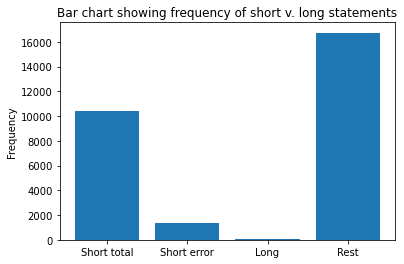

In [6]:
rest_count = len(df) - shorts['count_total'] - longs['count_total']
x = np.arange(4)
counts = [shorts['count_total'], shorts['count_error'], longs['count_total'], rest_count]
labels = ['Short total', 'Short error', 'Long', 'Rest']
fig, ax = plt.subplots()
plt.bar(x, counts)
plt.xticks(x, labels)
ax.set_ylabel('Frequency')
ax.set_title('Bar chart showing frequency of short v. long statements')
plt.show()

### 3.2 Frequency of statements by industry
Next, let's check out the frequency of statements by industry. Nothing to do with word count here; we just want to see which industries have contributed relatively more statements.

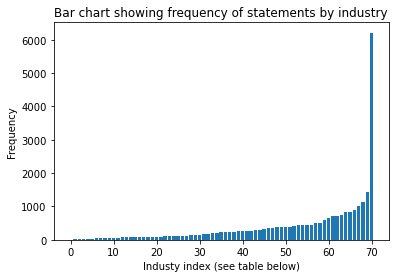

In [7]:
sorted_industries = OrderedDict(sorted(industries.items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries))
counts = list(sorted_industries.values())
labels = list(sorted_industries.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of statements by industry')
plt.show()

Here's a table which maps index (on the x-axis of the chart) to industry. "Industry unknown" has the highest proportion of statements.

In [8]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels)), labels, counts):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 2     | Mortgage Real Estate Investment Trusts (REITs)
1     | 16    | Health Care Technology
2     | 16    | Thrifts & Mortgage Finance
3     | 32    | Wireless Telecommunication Services
4     | 34    | Biotechnology
5     | 39    | Tobacco
6     | 46    | Life Sciences Tools & Services
7     | 51    | Multi-Utilities
8     | 53    | Equity Real Estate Investment Trusts (REITs)
9     | 56    | Gas Utilities
10    | 61    | Industrial Conglomerates
11    | 65    | Airlines
12    | 72    | Multiline Retail
13    | 76    | Household Products
14    | 82    | Water Utilities
15    | 86    | Leisure Products
16    | 86    | Personal Products
17    | 87    | Paper & Forest Products
18    | 95    | Construction Materials
19    | 97    | Communications Equipment
20    | 99    | Internet Software & Services
21    | 99    | Consumer Finance
22    | 108   | Independent Power and Renewable Electricity Producers
23    | 110   | Transportation Infrastructure
24    |

Let's see how the frequency of statements changes when only considering short and long statements. 

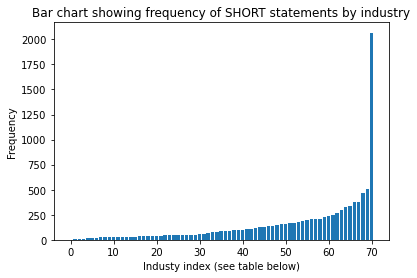

In [9]:
sorted_industries_short = OrderedDict(sorted(shorts['industries'].items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries_short))
counts_short = list(sorted_industries_short.values())
labels_short = list(sorted_industries_short.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts_short)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of SHORT statements by industry')
plt.show()

In [10]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels_short)), labels_short, counts_short):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 1     | Mortgage Real Estate Investment Trusts (REITs)
1     | 3     | Thrifts & Mortgage Finance
2     | 3     | Health Care Technology
3     | 9     | Biotechnology
4     | 13    | Wireless Telecommunication Services
5     | 15    | Life Sciences Tools & Services
6     | 21    | Multi-Utilities
7     | 23    | Industrial Conglomerates
8     | 24    | Tobacco
9     | 24    | Gas Utilities
10    | 25    | Consumer Finance
11    | 26    | Personal Products
12    | 28    | Equity Real Estate Investment Trusts (REITs)
13    | 28    | Airlines
14    | 29    | Multiline Retail
15    | 32    | Automobiles
16    | 34    | Household Products
17    | 36    | Construction Materials
18    | 37    | Transportation Infrastructure
19    | 37    | Leisure Products
20    | 41    | Technology Hardware, Storage & Peripherals
21    | 42    | Paper & Forest Products
22    | 44    | Marine
23    | 45    | Water Utilities
24    | 45    | Internet Software & Services
25    | 

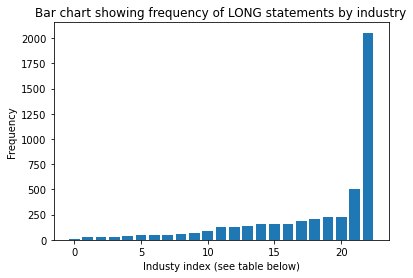

In [11]:
sorted_industries_long = OrderedDict(sorted(longs['industries'].items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries_long))
counts_long = list(sorted_industries_long.values())
labels_long = list(sorted_industries_long.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts_long)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of LONG statements by industry')
plt.show()

In [12]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels_long)), labels_long, counts_long):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 10    | Consumer Finance
1     | 23    | Household Products
2     | 24    | Industrial Conglomerates
3     | 28    | Food & Staples Retailing
4     | 33    | Water Utilities
5     | 46    | Air Freight & Logistics
6     | 47    | Insurance
7     | 48    | Road & Rail
8     | 56    | Specialty Retail
9     | 63    | Beverages
10    | 85    | Hotels, Restaurants & Leisure
11    | 127   | Electrical Equipment
12    | 129   | Trading Companies & Distributors
13    | 140   | Media
14    | 156   | Textiles, Apparel & Luxury Goods
15    | 158   | Diversified Consumer Services
16    | 160   | Capital Markets
17    | 189   | Machinery
18    | 206   | Oil, Gas & Consumable Fuels
19    | 228   | Food Products
20    | 229   | Electronic Equipment, Instruments & Components
21    | 500   | Professional Services
22    | 2054  | Industry unknown


### 3.3 UK v. rest
Finally, let's explore how the word count distributions change depending on whether the statements were published in response to the UK Modern Slavery Act.

First, how many statements are published in response to the UK Modern Slavery Act?

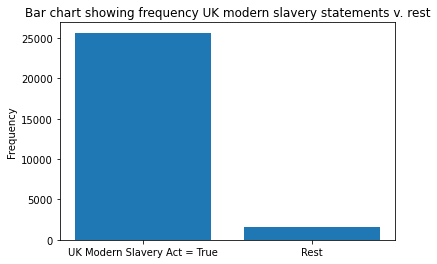

In [13]:
x = np.arange(2)
counts = [len(word_counts['UK_modern_slavery_act_true']), len(word_counts['rest'])]
labels = ['UK Modern Slavery Act = True', 'Rest']
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts)
plt.xticks(x, labels)
ax.set_ylabel('Frequency')
ax.set_title('Bar chart showing frequency UK modern slavery statements v. rest')
plt.show()

An overwhelming majority!
So, how do the word count distributions change for this partitition?

Let's first plot the word counts over all statements as a histogram. We'll use a log scale on the x-axis to improve interpretability, because word counts vary over several orders of magnitude between documents.

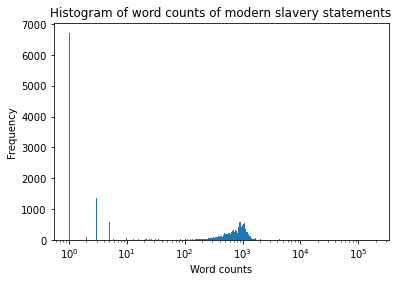

In [14]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['total'], bins=np.logspace(0, np.log10(max(word_counts['total'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements')
ax.set_xscale('log')
plt.show()

Now, how does this distribution change when considering our UK Modern Slavery Act partitition?

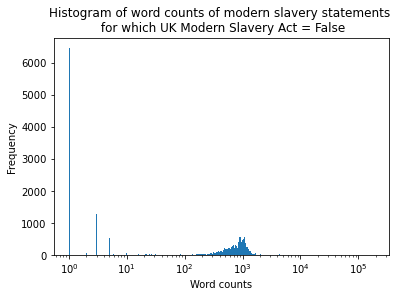

In [15]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['UK_modern_slavery_act_true'], bins=np.logspace(0, np.log10(max(word_counts['UK_modern_slavery_act_true'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements \n for which UK Modern Slavery Act = False')
ax.set_xscale('log')
plt.show()

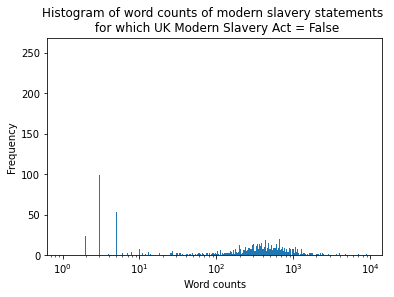

In [16]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['rest'], bins=np.logspace(0, np.log10(max(word_counts['rest'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements \n for which UK Modern Slavery Act = False')
ax.set_xscale('log')
plt.show()